# HW 3: Neural Machine Translation

In this homework you will build a full neural machine translation system using an attention-based encoder-decoder network to translate from German to English. The encoder-decoder network with attention forms the backbone of many current text generation systems. See [Neural Machine Translation and Sequence-to-sequence Models: A Tutorial](https://arxiv.org/pdf/1703.01619.pdf) for an excellent tutorial that also contains many modern advances.

## Goals


1. Build a non-attentional baseline model (pure seq2seq as in [ref](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)). 
2. Incorporate attention into the baseline model ([ref](https://arxiv.org/abs/1409.0473) but with dot-product attention as in class notes).
3. Implement beam search: review/tutorial [here](http://www.phontron.com/slides/nlp-programming-en-13-search.pdf)
4. Visualize the attention distribution for a few examples. 

Consult the papers provided for hyperparameters, and the course notes for formal definitions.

This will be the most time-consuming assignment in terms of difficulty/training time, so we recommend that you get started early!

## Setup

This notebook provides a working definition of the setup of the problem itself. Feel free to construct your models inline, or use an external setup (preferred) to build your system.

In [1]:
# Text text processing library and methods for pretrained word embeddings
from torchtext import data
from torchtext import datasets
import torch
from torchtext.vocab import Vectors, GloVe
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from torch.optim.lr_scheduler import MultiStepLR
from matplotlib import pyplot as plt
from torch.nn.utils import clip_grad_norm
import numpy as np
import torch.nn.init as weight_init
import time
import os

We first need to process the raw data using a tokenizer. We are going to be using spacy, which can be installed via:  
  `[sudo] pip install spacy`  
  
Tokenizers for English/German can be installed via:  
  `[sudo] python -m spacy download en`  
  `[sudo] python -m spacy download de`
  
This isn't *strictly* necessary, and you can use your own tokenization rules if you prefer (e.g. a simple `split()` in addition to some rules to acccount for punctuation), but we recommend sticking to the above.

In [2]:
import spacy
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]


Note that we need to add the beginning-of-sentence token `<s>` and the end-of-sentence token `</s>` to the 
target so we know when to begin/end translating. We do not need to do this on the source side.

In [3]:
BOS_WORD = '<s>'
EOS_WORD = '</s>'
DE = data.Field(tokenize=tokenize_de)
EN = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, eos_token = EOS_WORD) # only target needs BOS/EOS

Let's download the data. This may take a few minutes.

**While this dataset of 200K sentence pairs is relatively small compared to others, it will still take some time to train. So we are going to be only working with sentences of length at most 20 for this homework. Please train only on this reduced dataset for this homework.**

In [4]:
MAX_LEN = 20
train, val, test = datasets.IWSLT.splits(exts=('.de', '.en'), fields=(DE, EN), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
print(train.fields)
print(len(train))
print(vars(train[0]))

{'trg': <torchtext.data.field.Field object at 0x7f12a43abfd0>, 'src': <torchtext.data.field.Field object at 0x7f12a7433f28>}
119076
{'trg': ['David', 'Gallo', ':', 'This', 'is', 'Bill', 'Lange', '.', 'I', "'m", 'Dave', 'Gallo', '.'], 'src': ['David', 'Gallo', ':', 'Das', 'ist', 'Bill', 'Lange', '.', 'Ich', 'bin', 'Dave', 'Gallo', '.']}


Now we build the vocabulary and convert the text corpus into indices. We are going to be replacing tokens that occurred less than 5 times with `<unk>` tokens, and take the rest as our vocab.

In [5]:
MIN_FREQ = 5
DE.build_vocab(train.src, min_freq=MIN_FREQ)
EN.build_vocab(train.trg, min_freq=MIN_FREQ)
print(DE.vocab.freqs.most_common(10))
print("Size of German vocab", len(DE.vocab))
print(EN.vocab.freqs.most_common(10))
print("Size of English vocab", len(EN.vocab))
print(EN.vocab.stoi["<s>"], EN.vocab.stoi["</s>"]) #vocab index for <s>, </s>

[('.', 113253), (',', 67237), ('ist', 24189), ('die', 23778), ('das', 17102), ('der', 15727), ('und', 15622), ('Sie', 15085), ('es', 13197), ('ich', 12946)]
Size of German vocab 13353
[('.', 113433), (',', 59512), ('the', 46029), ('to', 29177), ('a', 27548), ('of', 26794), ('I', 24887), ('is', 21775), ("'s", 20630), ('that', 19814)]
Size of English vocab 11560
2 3


Now we split our data into batches as usual. Batching for MT is slightly tricky because source/target will be of different lengths. Fortunately, `torchtext` lets you do this by allowing you to pass in a `sort_key` function. This will minimizing the amount of padding on the source side, but since there is still some padding you will inadvertendly "attend" to these padding tokens. 

One way to get rid of padding is to pass a binary `mask` vector to your attention module so its attention score (before the softmax) is minus infinity for the padding token. Another way (which is how we do it for our projects, e.g. opennmt) is to manually sort data into batches so that each batch has exactly the same source length (this means that some batches will be less than the desired batch size, though).

However, for this homework padding won't matter too much, so it's fine to ignore it.

In [6]:
BATCH_SIZE = 64
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=BATCH_SIZE, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))

Let's check to see that the BOS/EOS token is indeed appended to the target (English) sentence.

In [7]:
batch = next(iter(train_iter))
print("Source")
print(batch.src)
print("Target")
print(batch.trg)


Source
Variable containing:

Columns 0 to 12 
 4087   159   159     0   159  1483   159   159   176   204   159   159  3038
    2     2     2    16   122     2     2     2    16     2     2     2     2
    1     1     1     1     1     1     1     1     1     1     1     1     1

Columns 13 to 25 
  159   159   159     0   159  2227     0   159   159   266  9632   159  1213
    2     2     2     2     2     2     2     2     2     2     2     2   122
    1     1     1     1     1     1     1     1     1     1     1     1     1

Columns 26 to 38 
  159   159   743   159   775  2227    77   159   159   159   159   159     0
    2     2     2     2     2     2    16     2     2     2     2     2     2
    1     1     1     1     1     1     1     1     1     1     1     1     1

Columns 39 to 51 
  159   159   204    73   312  7262   159   159   159   159     0  5802   204
  122     2     2  6455     2     2     2     2     2     2   122     2     2
    1     1     1     1     1     1    

Success! Now that we've processed the data, we are ready to begin modeling.

## Assignment

Now it is your turn to build the models described at the top of the assignment. 

When a model is trained, use the following test function to produce predictions, and then upload to the kaggle competition: https://www.kaggle.com/c/cs287-hw3-s18/

For the final Kaggle test, we will provide the source sentence, and you are to predict the **first three words of the target sentence**. The source sentence can be found under `source_test.txt`

In [9]:
!head source_test.txt

head: cannot open 'source_test.txt' for reading: No such file or directory


Similar to HW1, you are to predict the 100 most probable 3-gram that will begin the target sentence. The submission format will be as follows, where each word in the 3-gram will be separated by "|", and each 3-gram will be separated by space. For example, here is what an example submission might look like with 5 most-likely 3-grams (instead of 100).

```
id,word
1,Newspapers|talk|about When|I|was Researchers|call|the Twentysomethings|like|Alex But|before|long
2,That|'s|what Newspapers|talk|about You|have|robbed It|'s|realizing My|parents|wanted
3,We|forget|how We|think|about Proust|actually|links Does|any|other This|is|something
4,But|what|do And|it|'s They|'re|on My|name|is It|only|happens
```

When you print out your data, you will need to escape quotes and commas with the following command so that Kaggle does not complain. 

In [8]:
use_cuda = torch.cuda.is_available()

In [9]:
def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, 
                      -1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)

In [10]:
class AttnDecoderLSTM(nn.Module):
    def __init__(self, hidden_size=200, context_size=200, output_size=11560, n_layers = 2, dropout= 0.3, bidirectional=False):
        super(AttnDecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.context_size = context_size
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout, inplace=True)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(self.hidden_size+self.context_size, self.hidden_size, self.n_layers, bidirectional=bidirectional)
        for param in self.lstm.parameters():
            nn.init.uniform(param, -0.08, 0.08)
        self.out = nn.Linear(self.hidden_size+self.context_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_seq, hidden, context):
        embedded = self.embedding(input_seq).unsqueeze(0)
        embedded = self.dropout(embedded)
        #print(embedded.size(),context.size())
        combined = torch.cat([embedded, context.permute(1,0,2)],2)
        output, hidden = self.lstm(combined, hidden)
        output = output.squeeze(0)
        output = self.softmax(self.out(torch.cat([output,context.squeeze(1)],1)))
        return output, hidden

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seqs, target_seqs):
        batch_size = input_seqs.size(1)
        target_length = target_seqs.size(0)
        vocab_size = self.decoder.output_size
        if use_cuda:
            outputs = Variable(torch.zeros(target_length, batch_size, vocab_size)).cuda()
        else:
            outputs = Variable(torch.zeros(target_length, batch_size, vocab_size))
        encoder_output, hidden = self.encoder(input_seqs, None)
        output = Variable(target_seqs.data[0, :]) 
        for t in range(1, target_length):
            output, hidden = self.decoder(output, hidden)
            outputs[t] = output
            #best = output[0].data.max(1)[1]
            if use_cuda:
                output = Variable(target_seqs.data[t]).cuda()
                #output = Variable(best).cuda()
            else:
                output = Variable(target_seqs.data[t])
                #output = Variable(best)
        return outputs
    
    def batch_train(self, optimizer, train_iter, vocab_size, grad_clip=2):
        self.train()
        total_loss = 0
        pad = EN.vocab.stoi['<pad>']
        curr_time = time.time()
        for b, batch in enumerate(train_iter):
            source = flip(batch.src, 0)
            target = batch.trg
            if use_cuda:
                source, target = source.cuda(), target.cuda()
            optimizer.zero_grad()
            output = self.forward(source, target)
            loss = F.cross_entropy(output[1:].view(-1, vocab_size),
                                   target[1:].contiguous().view(-1),
                                   ignore_index=pad)
            loss.backward()
            clip_grad_norm(self.parameters(), grad_clip)
            optimizer.step()
            total_loss += loss.data[0]

            if b % 1000 == 0 and b != 0:
                total_loss = total_loss / 1000
                print("[%d][loss:%5.2f][pp:%5.2f][time:%5.2f]" %
                      (b, total_loss, math.exp(total_loss), time.time() - curr_time))
                total_loss = 0
                curr_time = time.time()
                
                
    def predict(self, val_iter, vocab_size):
        self.eval()
        pad = EN.vocab.stoi['<pad>']
        total_loss = 0
        for batch in val_iter:
            source = flip(batch.src, 0)
            target = batch.trg
            if use_cuda:
                source = Variable(source.data.cuda(), volatile=True)
                target = Variable(target.data.cuda(), volatile=True)
            output = self.forward(source, target)
            loss = F.cross_entropy(output[1:].view(-1, vocab_size),
                                   target[1:].contiguous().view(-1),
                                   ignore_index=pad)
            total_loss += loss.data[0]
        return total_loss / len(val_iter)

In [12]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size = 13352, hidden_size = 200, n_layers=2, dropout=0.3, bidirectional=None):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = n_layers
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx = 1)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional=bidirectional, dropout = dropout)
        for param in self.lstm.parameters():
            nn.init.uniform(param, -0.08, 0.08)
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden
        
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size=200, output_size=11560, n_layers = 2, dropout= 0.3, bidirectional=None):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout, inplace=True)
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx = 1)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers, bidirectional=bidirectional, dropout=dropout)
        for param in self.lstm.parameters():
            nn.init.uniform(param, -0.08, 0.08)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_seq, hidden):
        embedded = self.embedding(input_seq).unsqueeze(0)
        embedded = self.dropout(embedded)
        output, hidden = self.lstm(embedded, hidden)
        output = output.squeeze(0)
        output = self.softmax(self.out(output))
        return output, hidden

In [13]:
# encoder = EncoderLSTM(input_size = len(DE.vocab), hidden_size = 200, n_layers=2, dropout=0.3, bidirectional=None)
# decoder = DecoderLSTM(hidden_size=200, output_size = len(EN.vocab), n_layers = 2, dropout= 0.3, bidirectional=None)
# seq2seq = Seq2Seq(encoder, decoder).cuda()
# epoch_num = 13
# optimizer = optim.SGD(seq2seq.parameters(), lr=1)
# scheduler = MultiStepLR(optimizer, milestones=range(9, epoch_num), gamma=0.5)

In [14]:
class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder, use_true = True):
        super(Seq2SeqAttn, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.last_hidden_enc = (self.encoder.num_layers*(self.encoder.bidirectional*2)) - 1
        self.use_true = use_true # want to feed true last words in when training
        
    def forward(self, input_seqs, target_seqs, output_att = False):
        batch_size = input_seqs.size(1)
        target_length = target_seqs.size(0)
        vocab_size = self.decoder.output_size
        self.use_true = not(output_att)
        
        
        encoder_output, hidden = self.encoder(input_seqs, None)
        
        output = Variable(target_seqs.data[0, :])
        att_prob_list = []
        sentence = [target_seqs.data[0, :][0]]
        
        if output_att == False:
            outputs = Variable(torch.zeros(target_length, batch_size, vocab_size)).cuda()
            for t in range(1, target_length):

                #context = Variable(torch.zeros(batch_size,self.encoder.hidden_size)).cuda()

                #print(context.size())

                encoder_output_attn = encoder_output.transpose(0,1)
                hidden_attn = hidden[0][self.last_hidden_enc,:,:]

                hidden_attn=hidden_attn.unsqueeze(2)
                #print(hidden_attn.size(), encoder_output_attn.size())
                att_probs = torch.bmm(encoder_output_attn, hidden_attn)
                att_prob_list.append(att_probs.cpu().data.numpy())
                context = torch.bmm(att_probs.transpose(1,2), encoder_output_attn)
    #             #loop over examples in batch
    #             for i in range(batch_size):

    #                 #print(encoder_output[:,i,:].size())
    #                 #print(hidden[0][1,i,:].size())

    #                 #calculate attention probabilities

    #                 att_probs = torch.matmul(encoder_output[:,i,:],hidden[0][self.last_hidden_enc,i,:])

    #                 #print(att_probs.size())

    #                 #now get "expected" for each element in batch
    #                 context[i,:] = torch.matmul(att_probs,encoder_output[:,i,:])


                output, hidden = self.decoder(output, hidden, context)

                outputs[t] = output

                #use true values only if training/validating model
                if self.use_true:
                    output = Variable(target_seqs.data[t]).cuda()
                else:
                    output = Variable(output[0].data.max(0)[1]).cuda()
                    sentence.append(output.data[0])
                    if output.data[0] == 3:
                        break
        else:
            t = 1
            while True:

                #context = Variable(torch.zeros(batch_size,self.encoder.hidden_size)).cuda()

                #print(context.size())

                encoder_output_attn = encoder_output.transpose(0,1)
                hidden_attn = hidden[0][self.last_hidden_enc,:,:]

                hidden_attn=hidden_attn.unsqueeze(2)
                #print(hidden_attn.size(), encoder_output_attn.size())
                att_probs = torch.bmm(encoder_output_attn, hidden_attn)
                att_prob_list.append(att_probs.cpu().data.numpy())
                context = torch.bmm(att_probs.transpose(1,2), encoder_output_attn)
    #             #loop over examples in batch
    #             for i in range(batch_size):

    #                 #print(encoder_output[:,i,:].size())
    #                 #print(hidden[0][1,i,:].size())

    #                 #calculate attention probabilities

    #                 att_probs = torch.matmul(encoder_output[:,i,:],hidden[0][self.last_hidden_enc,i,:])

    #                 #print(att_probs.size())

    #                 #now get "expected" for each element in batch
    #                 context[i,:] = torch.matmul(att_probs,encoder_output[:,i,:])


                output, hidden = self.decoder(output, hidden, context)

                #use true values only if training/validating model
                if self.use_true:
                    output = Variable(target_seqs.data[t]).cuda()
                else:
                    output = Variable(output[0].data.max(0)[1]).cuda()
                    sentence.append(output.data[0])
                    if output.data[0] == 3:
                        break
                t += 1
        if output_att:
            return att_prob_list, sentence
        return outputs
    
    def batch_train(self, optimizer, train_iter, vocab_size, grad_clip=10):
        self.train()
        total_loss = 0
        pad = EN.vocab.stoi['<pad>']
        curr_time = time.time()
        for b, batch in enumerate(train_iter):
            source = flip(batch.src, 0)
            target = batch.trg
            if use_cuda:
                source, target = source.cuda(), target.cuda()
            optimizer.zero_grad()
            output = self.forward(source, target)
            loss = F.cross_entropy(output[1:].view(-1, vocab_size),
                                   target[1:].contiguous().view(-1),
                                   ignore_index=pad)
            loss.backward()
            clip_grad_norm(self.parameters(), grad_clip)
            optimizer.step()
            total_loss += loss.data[0]

            if b % 1000 == 0 and b != 0:
                total_loss = total_loss / 1000
                print("[%d][loss:%5.2f][pp:%5.2f][time:%5.2f]" %
                      (b, total_loss, math.exp(total_loss), time.time() - curr_time))
                total_loss = 0
                curr_time = time.time()
    '''
    def beam_search(self, input_seq, beam_size, search_time, target_vocab, n = 10):
        
        encoder_output, hidden = self.encoder(input_seq, None)
        
        #here we track the strings still in our beam
        track = [None]*beam_size
        
        # in worst case, take beam_size candidates from one former state
        poss_next = np.min([beam_size, len(target_vocab)])
        
        # next states that we might want to keep around
        possible_next = [None]*(beam_size*poss_next)
        
        # list of complete strings to keep around
        final_candidates = []
        
        # first state we have in our beam
        track[0] = ([target_vocab.stoi["<s>"]], hidden, 0)
        num_tracked = 1
        
        #start time
        start = time.time()
        
        #track no. of steps we've taken
        steps = 0
        
        #continue looping until we've used search time
        while time.time() < start + search_time:
            
            steps += 1
            
            #track where we are in the list of possible next values
            poss_counter = 0
            
            for i in range(num_tracked):
                
                att_probs = torch.matmul(encoder_output[:,0,:],track[i][1][0][self.last_hidden_enc,0,:].cuda())
            
                context = torch.matmul(att_probs,encoder_output[:,0,:].cuda())
                
                print(torch.LongTensor(track[i][0][-1]))
                output, hidden = self.decoder(Variable(torch.LongTensor(track[i][0][-1])).cuda(), (x.cuda() for x in hidden), context.cuda())
                
                log_output = torch.log(output)
                
                top_next, idx = torch.topk(log_output, poss_next)
                
                for j in range(len(top_next)):
                    
                    if idx[j] != target_vocab.stoi["</s>"]:
                        
                        possible_next[poss_counter+j] = (log_output[idx[j]] + track[i][2],top_next[j], idx[j], i, steps)
                    
                        poss_counter += 1
                        
                    else:
                        
                        #we have a complete string
                        final_candidates += [(top_next[j] + track[i][2],track[i][0]+[idx[j]])]
                    
                    
            if poss_counter < beam_search:
                
                print("less possible next states than beam size. Seems unlikely this would ever happen.")
                
                break
                
            #sort our possible next states and choose
            hq.heapify(possible_next[:poss_counter])
            largest = hq.nlargest(beam_size, possible_next[:poss_counter])
            
            num_tracked = 0
            
            #now loop over and put everything we want to keep in our track array
            for k in range(poss_counter):
                parent = track[possible_next[k][i]]
                track[k] = (parent[0] + [possible_next[k][1]], hidden, possible_next[k][0])
                num_tracked += 1
                
        #finally, sort our final candidates
        hq.heapify(final_candidates)
        final = hq.nlargest(n, final_candidates)
        
        return final
                
    '''        
        
    def predict(self, val_iter, vocab_size):
        self.eval()
        pad = EN.vocab.stoi['<pad>']
        total_loss = 0
        for batch in val_iter:
            source = batch.src
            target = batch.trg
            if use_cuda:
                source = Variable(source.data.cuda(), volatile=True)
                target = Variable(target.data.cuda(), volatile=True)
            output = self.forward(source, target)
            loss = F.cross_entropy(output[1:].view(-1, vocab_size),
                                   target[1:].contiguous().view(-1),
                                   ignore_index=pad)
            total_loss += loss.data[0]
        return total_loss / len(val_iter)

In [15]:
encoder = EncoderLSTM(input_size = len(DE.vocab), hidden_size = 200, n_layers=2, dropout=0.3, bidirectional=False)
decoder = AttnDecoderLSTM(hidden_size=200, context_size = 200, output_size = len(EN.vocab), n_layers = 2, dropout= 0.3, bidirectional=None)
seq2seq = Seq2SeqAttn(encoder, decoder).cuda()
epoch_num = 5
optimizer = optim.SGD(seq2seq.parameters(), lr=1)
scheduler = MultiStepLR(optimizer, milestones=range(9, epoch_num), gamma=0.5)

In [ ]:
best_val_loss = None
#seq2seq.load_state_dict(torch.load("./.save/seq2seq_4.pt"))
for i in range(epoch_num):
    seq2seq.batch_train(optimizer, train_iter,len(EN.vocab), grad_clip = 4)
    val_loss = seq2seq.predict(val_iter, len(EN.vocab))
    print("[Epoch:%d] val_loss:%5.3f | val_pp:%5.2fS"
          % (i, val_loss, math.exp(val_loss)))

    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        print("[!] saving model...")
        torch.save(seq2seq.state_dict(), 'save/seq2seq_%d.pt' % (i))
        best_val_loss = val_loss
    scheduler.step()
test_loss = seq2seq.predict(test_iter, len(EN.vocab))
print("[TEST] loss:%5.2f" % test_loss)

In [51]:
for batch in train_iter:
    True

In [19]:
batch.src

Variable containing:
     9   2431     20  ...      26     20     23
    47     21    168  ...       4    290      4
   165     29    106  ...       4   1624      7
        ...            ⋱           ...         
  1874     22      0  ...       1      1      1
     0      0    152  ...       1      1      1
     2      2      2  ...       1      1      1
[torch.LongTensor of size 20x58]

In [16]:
encoder = EncoderLSTM(input_size = len(DE.vocab), hidden_size = 200, n_layers=2, dropout=0.3, bidirectional=False)
decoder = AttnDecoderLSTM(hidden_size=200, context_size = 200, output_size = len(EN.vocab), n_layers = 2, dropout= 0.3, bidirectional=None)
seq2seq = Seq2SeqAttn(encoder, decoder).cuda()
seq2seq.load_state_dict(torch.load('seq2seq_a_11.pt'))

In [124]:
import matplotlib.ticker as ticker
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words.split(' '))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [123]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [285]:
att_weights = np.array(seq2seq.forward(batch.src[:, 4].unsqueeze(1).cuda(), batch.trg[:, 4].unsqueeze(1).cuda(), output_att = True)[0])

In [289]:
seq2seq.forward(batch.src[:, 4].unsqueeze(1).cuda(), batch.trg[:, 4].unsqueeze(1).cuda(), output_att = True)[1]

[2, 0, 19, 198, 15, 32, 19, 138, 198, 15, 4, 3]

In [299]:
att_weights[:-1, :,  1:].shape

(10, 1, 11, 1)

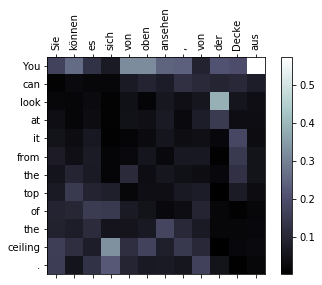

In [144]:
translation = seq2seq.forward(batch.src[:, 55].unsqueeze(1).cuda(), batch.trg[:, 55].unsqueeze(1).cuda(), output_att = True)
att_weights = np.array(translation[0])
att_weights = np.array([item[0] for item in att_weights[:-1, :,  1:]])
att_weights = att_weights.reshape((len(att_weights), att_weights.shape[1]))
att_weights = np.array([softmax(item) for item in att_weights.T]).T
showAttention(" ".join([DE.vocab.itos[i] for i in batch.src[:, 55].data]), " ".join([EN.vocab.itos[i] for i in translation[1][1:]]), att_weights)

In [186]:
def escape(l):
    return l.replace("\"", "<quote>").replace(",", "<comma>")

In [73]:
best_val_loss = None
for i in range(epoch_num):
    seq2seq.batch_train(optimizer, train_iter,len(EN.vocab), grad_clip = 2)
    val_loss = seq2seq.predict(val_iter, len(EN.vocab))
    print("[Epoch:%d] val_loss:%5.3f | val_pp:%5.2f"
          % (i, val_loss, math.exp(val_loss)))

    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        print("[!] saving model...")
        torch.save(seq2seq.state_dict(), 'save/seq2seq_%d.pt' % (i))
        best_val_loss = val_loss
    scheduler.step()
test_loss = seq2seq.predict(test_iter, len(EN.vocab))
print("[TEST] loss:%5.2f" % test_loss)

[1000][loss: 5.31][pp:201.41][time:205.36]
[Epoch:0] val_loss:4.148 | val_pp:63.33
[!] saving model...
[1000][loss: 4.18][pp:65.34][time:202.74]
[Epoch:1] val_loss:3.817 | val_pp:45.49
[!] saving model...
[1000][loss: 3.88][pp:48.46][time:205.51]
[Epoch:2] val_loss:3.596 | val_pp:36.47
[!] saving model...
[1000][loss: 3.70][pp:40.64][time:202.14]
[Epoch:3] val_loss:3.456 | val_pp:31.70
[!] saving model...
[1000][loss: 3.58][pp:35.75][time:203.62]
[Epoch:4] val_loss:3.366 | val_pp:28.97
[!] saving model...
[1000][loss: 3.47][pp:32.26][time:203.44]
[Epoch:5] val_loss:3.287 | val_pp:26.77
[!] saving model...
[1000][loss: 3.39][pp:29.80][time:205.18]
[Epoch:6] val_loss:3.236 | val_pp:25.42
[!] saving model...
[1000][loss: 3.32][pp:27.57][time:203.59]
[Epoch:7] val_loss:3.176 | val_pp:23.94
[!] saving model...
[1000][loss: 3.27][pp:26.19][time:206.35]
[Epoch:8] val_loss:3.143 | val_pp:23.17
[!] saving model...
[1000][loss: 3.20][pp:24.60][time:203.93]
[Epoch:9] val_loss:3.100 | val_pp:22.20

NameError: name 'test_iter' is not defined

In [147]:
def escape(l):
    return l.replace("\"", "<quote>").replace(",", "<comma>")

You should perform your hyperparameter search/early stopping/write-up based on perplexity, not the above metric. (In practice, people use a metric called [BLEU](https://www.aclweb.org/anthology/P02-1040.pdf), which is roughly a geometric average of 1-gram, 2-gram, 3-gram, 4-gram precision, with a brevity penalty for producing translations that are too short.)

Finally, as always please put up a (short) write-up following the template provided in the repository:  https://github.com/harvard-ml-courses/cs287-s18/blob/master/template/
